## SHRINKAGE METHODS

## RIDGE REGRESSION: Hitters dataset

In [246]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error



import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency

from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.model_selection import train_test_split



In [247]:
Food = pd.read_csv("dataset/Food_Delivery_Times.csv")
print("Number of rows in the original dataset:", len(Food))

null_rows = Food.isnull().any(axis=1).sum()
print("Number of rows with missing values:", null_rows)

Food = Food.dropna()
print("Number of rows after removing missing values:", len(Food))

Food.head()

Number of rows in the original dataset: 1000
Number of rows with missing values: 117
Number of rows after removing missing values: 883


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


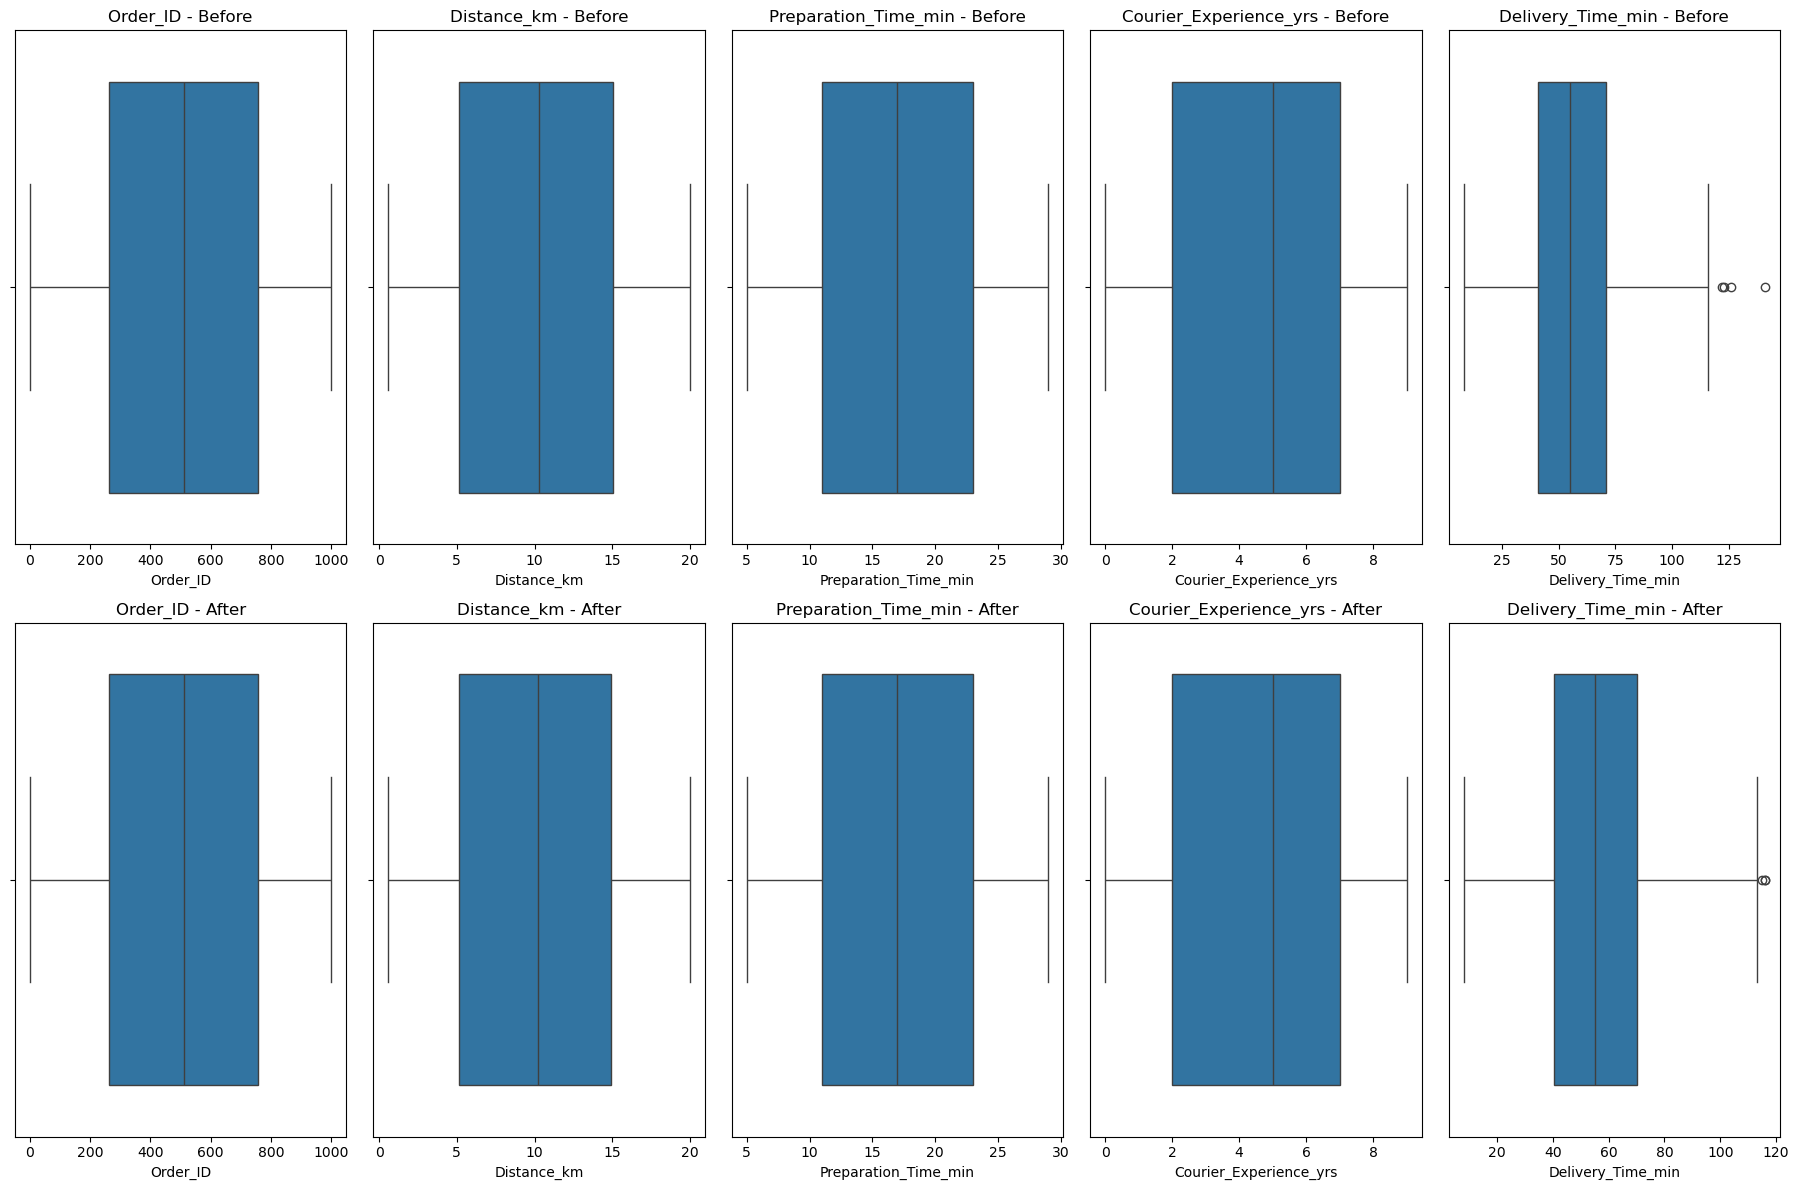

Number of rows after removing outliers 879


In [248]:
numeric_columns = Food.select_dtypes(include=['float64', 'int64']).columns

Food_original = Food.copy()

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numeric_columns:
    Food = remove_outliers(Food, col)

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_columns, 1):

    plt.subplot(2, len(numeric_columns), i)
    sns.boxplot(x=Food_original[col])
    plt.title(f"{col} - Before")

    plt.subplot(2, len(numeric_columns), len(numeric_columns) + i)
    sns.boxplot(x=Food[col])
    plt.title(f"{col} - After")

plt.tight_layout()
plt.show()

print("Number of rows after removing outliers", len(Food))

In [249]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']


model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,18.4314,1.467,12.564,0.000
Distance_km,2.9055,0.056,51.622,0.000
Weather[Foggy],8.0616,1.059,7.611,0.000
Weather[Rainy],4.9402,0.832,5.938,0.000
Weather[Snowy],10.2738,1.126,9.128,0.000
Weather[Windy],1.9968,1.129,1.769,0.077
Traffic_Level[Low],-12.2613,0.869,-14.102,0.000
Traffic_Level[Medium],-6.0433,0.865,-6.984,0.000
Time_of_Day[Evening],0.0829,0.826,0.100,0.920
Time_of_Day[Morning],-0.8775,0.817,-1.074,0.283


In [250]:
residuals = results.resid

residuals_std = np.std(residuals)
threshold = 2.9 * residuals_std

mask = np.abs(residuals) < threshold
Food = Food.loc[mask].copy()

print(f"Number of rows after removing outliers: {len(Food)}")

Number of rows after removing outliers: 860


---

# DA QUI

We continue the analysis of the model using shrinkage methods.  
These methods allow setting the coefficients of variables to zero.  
To do this, it makes sense to return to a model with all variables.  
This means adding back the categorical variables _Time_of_Day_ and _Vehicle_Type_.  
It is also important to normalize the model, as this ensures all variables are on the same scale. 

In [251]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

numerical_columns = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']

scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

model = sm.OLS(y, X)
results = model.fit()

summarize(results)


,coef,std err,t,P>|t|
intercept,59.5537,0.701,84.955,0.000
Distance_km,16.8426,0.228,73.852,0.000
Weather[Foggy],6.3464,0.768,8.264,0.000
Weather[Rainy],4.7687,0.593,8.044,0.000
Weather[Snowy],9.8532,0.804,12.262,0.000
Weather[Windy],2.8989,0.798,3.633,0.000
Traffic_Level[Low],-11.2475,0.623,-18.066,0.000
Traffic_Level[Medium],-5.3621,0.620,-8.653,0.000
Time_of_Day[Evening],-0.3425,0.591,-0.580,0.562
Time_of_Day[Morning],-0.5390,0.581,-0.927,0.354


- ## Ridge regression

We begin by splitting the database into train and test sets.  
Next, we search for the optimal lambda for ridge regression.  


In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
lambda_values = np.logspace(-2, 4, 300) 


In [253]:
pipeline = make_pipeline(StandardScaler(), Ridge())

param_grid = {'ridge__alpha': lambda_values}
ridge_cv = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=10) # key-fold con 10 valori
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.best_params_['ridge__alpha']
print(f"Best Ridge lambda: {best_alpha}")


Best Ridge lambda: 1.7680381784572086


We evaluate the test set using the lambda found.

In [254]:
ridge_best = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
ridge_best.fit(X_train, y_train)
ridge_pred = ridge_best.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)

coefficients = ridge_best.named_steps['ridge'].coef_

coeff_df = pd.DataFrame({'Variable': X_train.columns, 'Coefficient': coefficients})

print(coeff_df)



                  Variable  Coefficient
0                intercept     0.000000
1              Distance_km    16.921252
2           Weather[Foggy]     2.048377
3           Weather[Rainy]     1.621683
4           Weather[Snowy]     3.064244
5           Weather[Windy]     1.014522
6       Traffic_Level[Low]    -5.150850
7    Traffic_Level[Medium]    -2.279150
8     Time_of_Day[Evening]     0.109579
9     Time_of_Day[Morning]    -0.010385
10      Time_of_Day[Night]     0.175841
11       Vehicle_Type[Car]    -0.082883
12   Vehicle_Type[Scooter]    -0.197417
13    Preparation_Time_min     7.407239
14  Courier_Experience_yrs    -1.444747


From the results, we see that the less significant variables (also observed in previous models and methods) have coefficients very close to zero for ridge regression.  
This occurs because ridge regression shrinks coefficients of less relevant variables toward zero, improving model generalization.  
We also notice that the intercept is exactly zero.  

In [255]:
MSE = ridge_mse
RMSE = np.sqrt(MSE)

print("MSE", MSE) 
print("RMSE", RMSE)

MSE 41.90806681166175
RMSE 6.473644013356137


The results in this case are similar to those obtained previously with the three cross-validation methods (50%, LOOCV, and KF), with a slight improvement of about 2% referring to the RMSE.


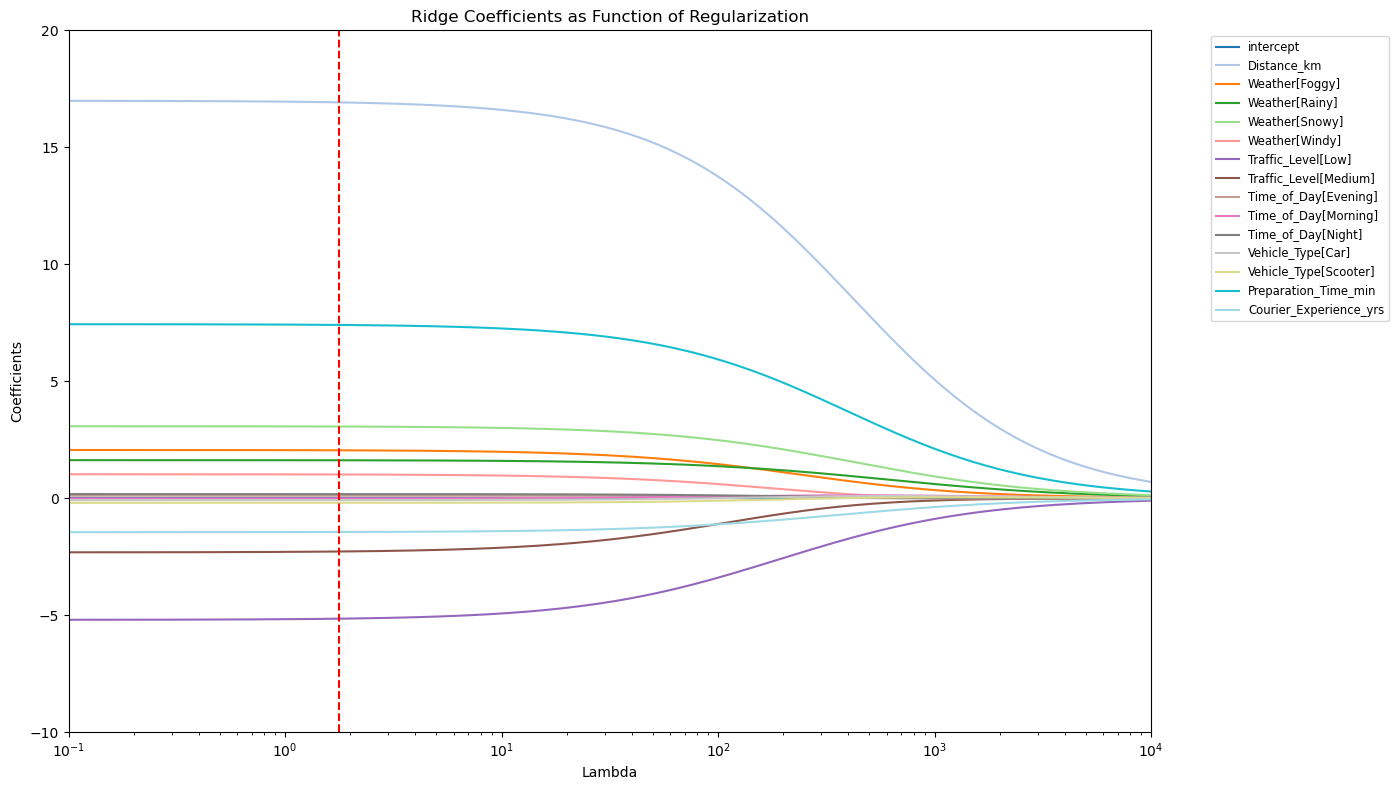

In [256]:
coefs = []
feature_names = X_train.columns 

for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=a))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['ridge'].coef_)

coefs = np.array(coefs)  

plt.figure(figsize=(14, 8))
ax = plt.gca()

colors = plt.cm.tab20(np.linspace(0, 1, len(feature_names)))

for idx, name in enumerate(feature_names):
    ax.plot(lambda_values, coefs[:, idx], label=name, color=colors[idx])

ax.set_xscale('log')  
plt.xlabel('Lambda')
plt.axvline(best_alpha, color='r', linestyle='--')  
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients as Function of Regularization')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.ylim(-10, 20)
plt.xlim(1e-1, 1e4)  

plt.show()


The results of the coefficients can also be seen in this graph, at the point corresponding to the red dashed line, which indicates the optimal lambda.  
It is noticeable that the important variables are those farthest from zero.  
It is also noticeable that ridge regression drives the coefficients toward zero as lambda increases.


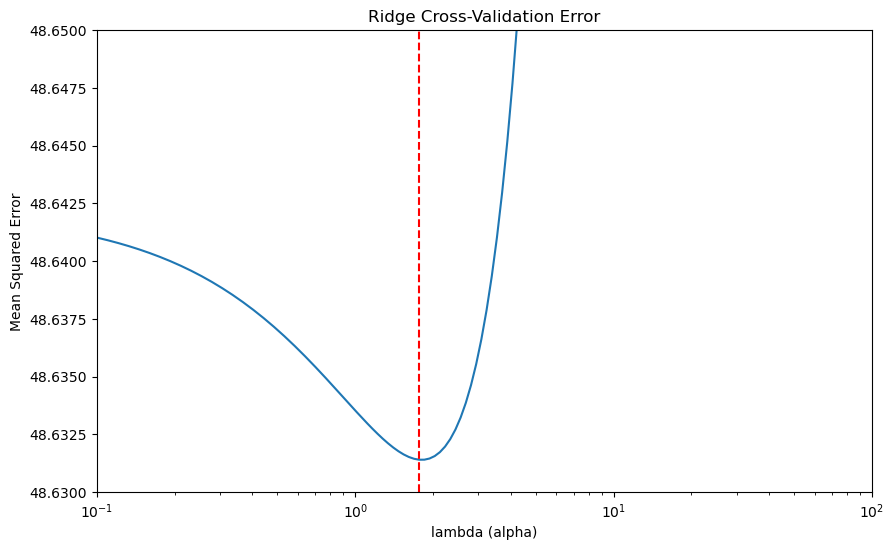

In [ ]:
mean_test_scores = -ridge_cv.cv_results_['mean_test_score'] 
alphas = ridge_cv.param_grid['ridge__alpha']

plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mean_test_scores)
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Cross-Validation Error')
plt.ylim(48.63, 48.65)
plt.xlim(1e-1, 1e2)
plt.show()


In this other plot, we can see that the minimum MSE is found at the optimal lambda.


- ## Lasso regression

We will now proceed in the same manner with lasso regression.


In [258]:
lasso_pipe = make_pipeline(StandardScaler(), Lasso(max_iter=10000))

lasso_cv = GridSearchCV(lasso_pipe, 
                       {'lasso__alpha': lambda_values},
                       scoring='neg_mean_squared_error',
                       cv=10)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.best_params_['lasso__alpha']
print(f"Best Lasso lambda: {best_alpha}")

Best Lasso lambda: 0.10553861030365236


In [259]:
lasso_best = lasso_cv.best_estimator_
lasso_pred = lasso_best.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)

print(f"Number of initial coefficients: {len(feature_names)}")

final_coefs = lasso_best.named_steps['lasso'].coef_
print(f"Number of non-zero coefficients: {np.sum(final_coefs != 0)}")

coeff_df = pd.DataFrame({'Variable': feature_names, 'Coefficient': final_coefs})
print(coeff_df)


Number of initial coefficients: 15
Number of non-zero coefficients: 11
                  Variable  Coefficient
0                intercept     0.000000
1              Distance_km    16.894242
2           Weather[Foggy]     1.879118
3           Weather[Rainy]     1.423975
4           Weather[Snowy]     2.893828
5           Weather[Windy]     0.823138
6       Traffic_Level[Low]    -4.905907
7    Traffic_Level[Medium]    -2.025254
8     Time_of_Day[Evening]     0.000000
9     Time_of_Day[Morning]    -0.000000
10      Time_of_Day[Night]     0.048237
11       Vehicle_Type[Car]    -0.000000
12   Vehicle_Type[Scooter]    -0.084120
13    Preparation_Time_min     7.326051
14  Courier_Experience_yrs    -1.307976


With lasso regression, the less significant variables are driven exactly to zero, allowing for model simplification.  
Similarly, the intercept remains zero in this case as well.


In [260]:
MSE = lasso_mse
RMSE = np.sqrt(MSE)

print("MSE", MSE) 
print("RMSE", RMSE)

MSE 42.21212509283608
RMSE 6.497085892370215


The results compared to ridge regression are practically identical.


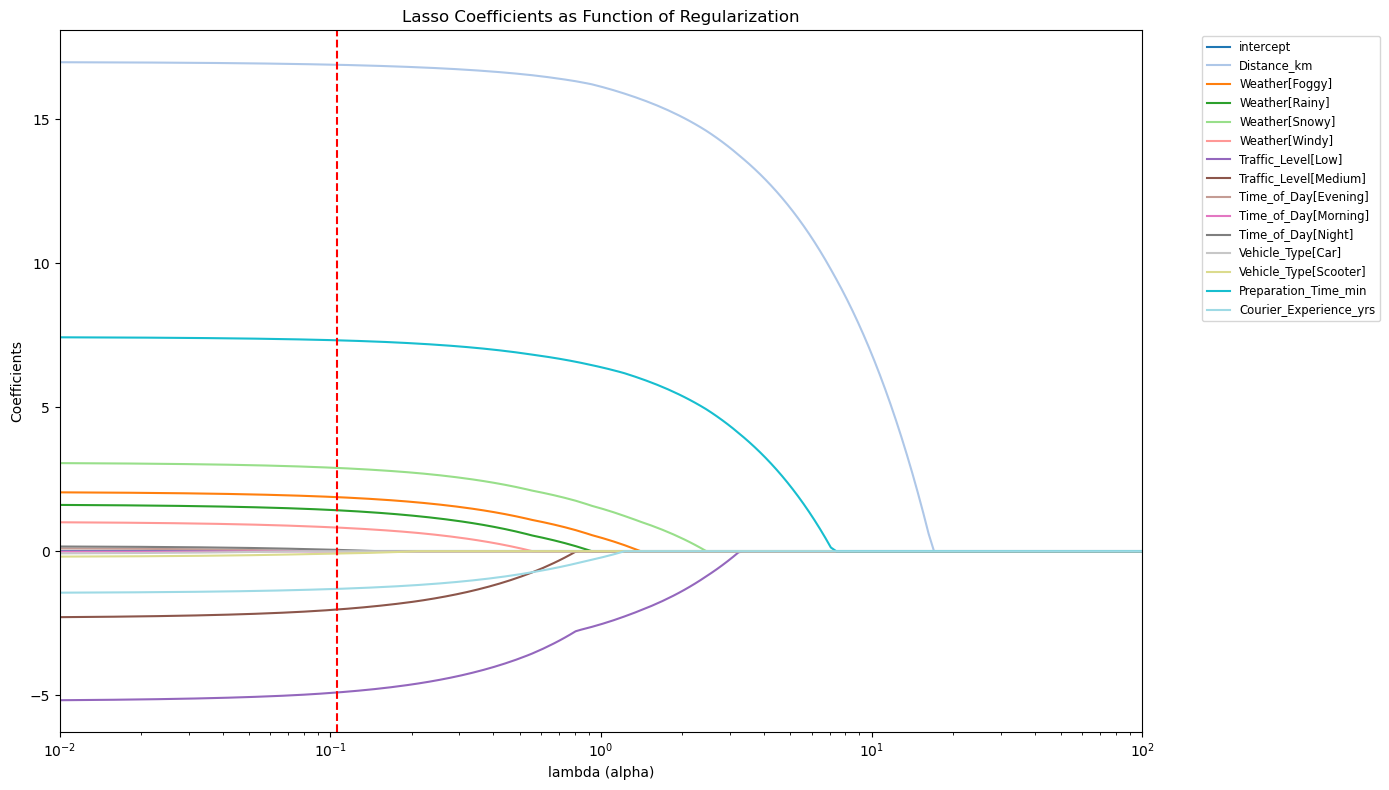

In [ ]:
coefs = []

for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=a, max_iter=10000))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

coefs = np.array(coefs)  

plt.figure(figsize=(14, 8))
ax = plt.gca()

colors = plt.cm.tab20(np.linspace(0, 1, len(feature_names)))

for idx, name in enumerate(feature_names):
    ax.plot(lambda_values, coefs[:, idx], label=name, color=colors[idx])

ax.set_xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as Function of Regularization')
plt.axvline(best_alpha, color='r', linestyle='--') 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  
plt.xlim(1e-2, 1e2)
plt.tight_layout()
plt.show()


Unlike the same plot for ridge regression, we notice that in lasso regression, the coefficients go exactly to zero as the optimal lambda increases.


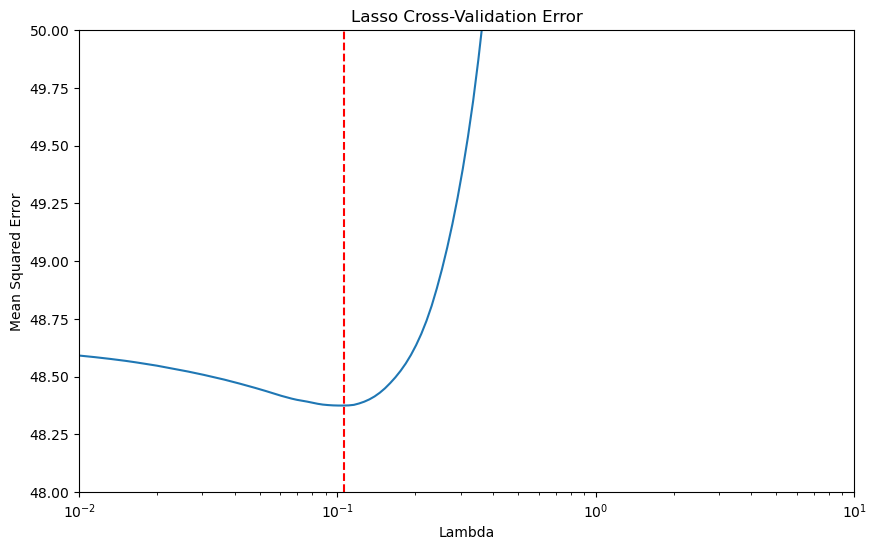

In [268]:
mean_test_scores = -lasso_cv.cv_results_['mean_test_score'] 
alphas = lasso_cv.param_grid['lasso__alpha']

plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mean_test_scores)
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Lasso Cross-Validation Error')
plt.ylim(48, 50)
plt.xlim(1e-2, 1e1)
plt.show()

As with the optimal lambda for ridge regression, the optimal lambda for lasso regression is also at the minimum of the MSE function.


---